## Importing libraries

In [1]:
%reload_ext

UsageError: Missing module name.


In [65]:
#Make the necessary imports
import matplotlib.pyplot as plt
import nltk
from nltk.tag import pos_tag
from sklearn_crfsuite import CRF, metrics
from sklearn.metrics import confusion_matrix
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amittimalsina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the data

In [3]:
"""
Load the training/testing data. 
input: conll format data, but with only 2 tab separated colums - words and NEtags.
output: A list where each item is 2 lists.  sentence as a list of tokens, NER tags as a list for each token.
"""
def load_data_conll(file_path):
    myoutput, words, tags = [], [], []
    fh = open(file_path)
    for line in fh:
        line = line.strip()
        if '\t' not in line:
            # sentence ended
            myoutput.append([words, tags])
            words, tags = [], []
        else:
            word, tag = line.split('\t')
            words.append(word)
            tags.append(tag)
    fh.close()
    return myoutput

In [4]:
# initializing data paths
train_path = 'Data/conll2003/train.txt'
test_path = 'Data/conll2003/test.txt'
val_path = 'Data/conll2003/valid.txt'

In [5]:
conll_train = load_data_conll(train_path)
conll_test = load_data_conll(test_path)

len(conll_train), len(conll_test)


(14040, 3452)

In [6]:
conll_test[0]

[['SOCCER',
  '-',
  'JAPAN',
  'GET',
  'LUCKY',
  'WIN',
  ',',
  'CHINA',
  'IN',
  'SURPRISE',
  'DEFEAT',
  '.'],
 ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']]

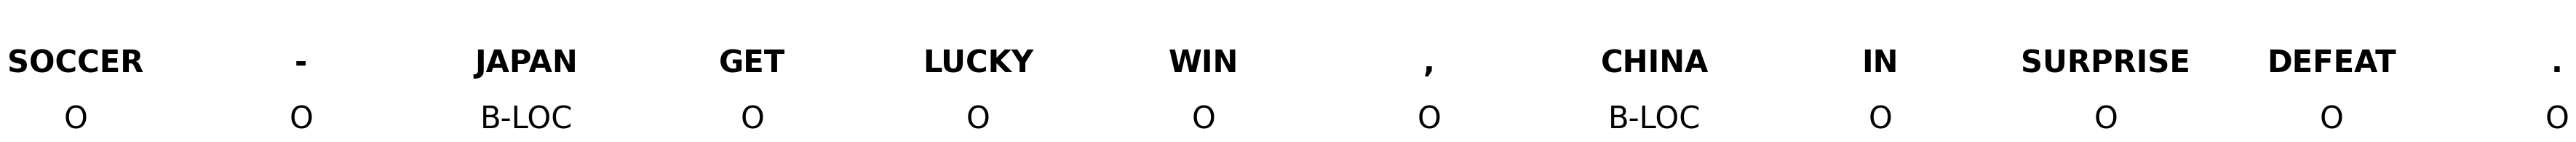

In [64]:
# Create a new figure
plt.figure(figsize=(10, 2))

# Plot the data
for i in range(len(conll_test[0][0])):
    plt.text(i * 0.4, 0.5, conll_test[0][0][i], ha='center', va='center', fontsize=30, fontweight='bold')
    plt.text(i * 0.4, 0, conll_test[0][1][i], ha='center', va='center', fontsize=30)

# Remove the axes
plt.axis('off')

# Show the plot
plt.show()

In [7]:
"""
Get features for all words in the sentence
Features:
- word context: a window of 2 words on either side of the current word, and current word.
- POS context: a window of 2 POS tags on either side of the current word, and current tag. 
input: sentence as a list of tokens.
output: list of dictionaries. each dict represents features for that word.
"""

def sent2feats(sentence):
    feats = []
    context_size = 2
    sen_tags = pos_tag(sentence) # This format is specific to this POS tagger
    for i in range(0, len(sentence)):
        word = sentence[i]
        wordfeats = {}
        # word features: word, prev 2 words, next 2 words in the sentence
        wordfeats['word'] = word
        if i == 0:
            wordfeats['prevWord'] = wordfeats['prevSecondWord'] = "<S>"
        elif i == 1:
            wordfeats['prevWord'] = sentence[0]
            wordfeats['prevSecondWord'] = '</S>'
        else:
            wordfeats['prevWord'] = sentence[i-1]
            wordfeats['prevSecondWord'] = sentence[i-2]
        
        # next two words as features
        if i == len(sentence)-2:
            wordfeats['nextWord'] = sentence[i+1]
            wordfeats['nextNextWord'] = '</S>'
        elif i==len(sentence)-1:
            wordfeats['nextWord'] = '</S>'
            wordfeats['nextNextWord'] = '</S>'
        else:
            wordfeats['nextWord'] = sentence[i+1]
            wordfeats['nextNextWord'] = sentence[i+2]

        #POS tag features: current tag, previous and next 2 tags.
        wordfeats['tag'] = sen_tags[i][1]
        if i == 0:
            wordfeats["prevTag"] = wordfeats["prevSecondTag"] = "<S>"
        elif i == 1:
            wordfeats["prevTag"] = sen_tags[0][1]
            wordfeats["prevSecondTag"] = "</S>"
        else:
            wordfeats["prevTag"] = sen_tags[i - 1][1]

            wordfeats["prevSecondTag"] = sen_tags[i - 2][1]
            # next two words as features
        if i == len(sentence) - 2:
            wordfeats["nextTag"] = sen_tags[i + 1][1]
            wordfeats["nextNextTag"] = "</S>"
        elif i == len(sentence) - 1:
            wordfeats["nextTag"] = "</S>"
            wordfeats["nextNextTag"] = "</S>"
        else:
            wordfeats["nextTag"] = sen_tags[i + 1][1]
            wordfeats["nextNextTag"] = sen_tags[i + 2][1]
        #That is it! You can add whatever you want!
        feats.append(wordfeats)
    return feats

## Extracting features

In [8]:
# Extract features from the conll data, after loading it
def get_feats_conll(conll_data):
    feats, labels = [], []
    for sentence in conll_data:
        feats.append(sent2feats(sentence[0]))
        labels.append(sentence[1])
    return feats, labels

In [9]:
trainfeats, trainlabels = get_feats_conll(conll_train)
testfeats, testlabels = get_feats_conll(conll_test)

In [10]:
testfeats[0]

[{'word': 'SOCCER',
  'prevWord': '<S>',
  'prevSecondWord': '<S>',
  'nextWord': '-',
  'nextNextWord': 'JAPAN',
  'tag': 'NNP',
  'prevTag': '<S>',
  'prevSecondTag': '<S>',
  'nextTag': ':',
  'nextNextTag': 'NNP'},
 {'word': '-',
  'prevWord': 'SOCCER',
  'prevSecondWord': '</S>',
  'nextWord': 'JAPAN',
  'nextNextWord': 'GET',
  'tag': ':',
  'prevTag': 'NNP',
  'prevSecondTag': '</S>',
  'nextTag': 'NNP',
  'nextNextTag': 'NNP'},
 {'word': 'JAPAN',
  'prevWord': '-',
  'prevSecondWord': 'SOCCER',
  'nextWord': 'GET',
  'nextNextWord': 'LUCKY',
  'tag': 'NNP',
  'prevTag': ':',
  'prevSecondTag': 'NNP',
  'nextTag': 'NNP',
  'nextNextTag': 'NNP'},
 {'word': 'GET',
  'prevWord': 'JAPAN',
  'prevSecondWord': '-',
  'nextWord': 'LUCKY',
  'nextNextWord': 'WIN',
  'tag': 'NNP',
  'prevTag': 'NNP',
  'prevSecondTag': ':',
  'nextTag': 'NNP',
  'nextNextTag': 'NNP'},
 {'word': 'LUCKY',
  'prevWord': 'GET',
  'prevSecondWord': 'JAPAN',
  'nextWord': 'WIN',
  'nextNextWord': ',',
  'tag':

In [11]:
testlabels[0]

['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']

### Training a model

In [12]:
def print_cm(cm, labels):
    print("\n")
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        sum = 0
        for j in range(len(labels)):
            cell = "%{0}.0f".format(columnwidth) % cm[i, j]
            sum =  sum + int(cell)
            print(cell, end=" ")
        print(sum) #Prints the total number of instances per cat at the end.

In [16]:
#python-crfsuite does not have a confusion matrix function, 
#so writing it using sklearn's confusion matrix and print_cm from github
def get_confusion_matrix(y_true,y_pred,labels):
    trues,preds = [], []
    for yseq_true, yseq_pred in zip(y_true, y_pred):
        trues.extend(yseq_true)
        preds.extend(yseq_pred)
    print_cm(confusion_matrix(trues,preds,labels=labels),labels)

In [44]:
def prepare_df(conll_test, y_pred):
    df = pd.DataFrame(columns=['text', 'ground_truth', 'pred'])

    data = []
    # Iterate through the list and add each inner list as a row
    for item, pred in zip(conll_test, y_pred):
        text = item[0]
        gt = item[1]
        data.append({'text': text, 'gt': gt, 'pred': pred})

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    return df

In [45]:
#Train a sequence model
def train_seq(X_train,Y_train,X_dev,Y_dev, raw_test_data):
   # crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=50, all_possible_states=True)
    crf = CRF(algorithm='lbfgs', c1=0.1, c2=10, max_iterations=50)#, all_possible_states=True)
    #Just to fit on training data
    crf.fit(X_train, Y_train)
    labels = list(crf.classes_)
    #testing:
    y_pred = crf.predict(X_dev)
    sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
    print(metrics.flat_f1_score(Y_dev, y_pred, average='weighted', labels=labels))
    print(metrics.flat_classification_report(Y_dev, y_pred, labels=sorted_labels))
    #print(metrics.sequence_accuracy_score(Y_dev, y_pred))
    get_confusion_matrix(Y_dev, y_pred,labels=sorted_labels)
    df = prepare_df(raw_test_data, y_pred)
    return crf, df

In [46]:
model, df = train_seq(trainfeats, trainlabels, testfeats, testlabels, conll_test)
print('Done with sequence model')

0.9252804799437758
              precision    recall  f1-score   support

           O       0.97      0.98      0.98     38289
       B-LOC       0.69      0.76      0.73      1668
       I-LOC       0.74      0.48      0.58       257
      B-MISC       0.66      0.29      0.40       701
      I-MISC       0.64      0.49      0.55       214
       B-ORG       0.67      0.55      0.61      1660
       I-ORG       0.57      0.70      0.63       834
       B-PER       0.77      0.77      0.77      1615
       I-PER       0.82      0.89      0.85      1156

    accuracy                           0.93     46394
   macro avg       0.73      0.66      0.68     46394
weighted avg       0.93      0.93      0.93     46394



                O  B-LOC  I-LOC B-MISC I-MISC  B-ORG  I-ORG  B-PER  I-PER 
         O  37581    121      4     21     30    186    193     88     65 38289
     B-LOC    150   1276      1     33      1     94     13     96      4 1668
     I-LOC     32      6    124      1  

In [71]:
# Set the display option to show full content within cells
pd.set_option('display.max_colwidth', None)
df.sample(5)

,text,gt,pred
864,"[Partizan, -, Dejan, Koturovic, 21]","[B-ORG, O, B-PER, I-PER, O]","[O, O, B-ORG, I-ORG, O]"
2757,"[5., Becky, Sundstrom, (, U.S., ), 1:25.39]","[O, B-PER, I-PER, O, B-LOC, O, O]","[O, B-PER, I-PER, O, B-LOC, O, O]"
2410,"[13., Barbara, Merlin, (, Italy, ), 1:18.67]","[O, B-PER, I-PER, O, B-LOC, O, O]","[O, B-PER, I-PER, O, B-LOC, O, O]"
387,"[COLORADO, 17, 6, 4, 97, 56, 38]","[B-ORG, O, O, O, O, O, O]","[B-ORG, O, O, O, O, O, O]"
159,"[basketball, championship, after, Thursday, 's, matches, (, tabulate, under]","[O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O]"
